# Draw how social environment influences NEV sales on US Map

In [1]:
import pandas as pd
import matplotlib.pylab as plt
import matplotlib
import numpy as np

import geopandas as gpd
from geopandas import GeoDataFrame

%matplotlib inline

## Parameters 

In [2]:
EV_SALE_DATASET = '../Processed_Data/Ev_sales.csv'
CLIMATE_DATASET = '../Processed_Data/climate_state.csv'
INCOME_DATASET = '../Processed_Data/incomes.csv'
TAX_DATASET = '../Processed_Data/policy_state.csv'
GDP_DATASET = '../Processed_Data/gdp.csv'

# https://eric.clst.org/tech/usgeojson/
# https://www.weather.gov/gis/USStates
USA_SHAPEFILE = '../Raw_Data/US_Map_5m.json'

# Load Datasets
## Load the EV sales dataset

In [3]:
df_EV = pd.read_csv(EV_SALE_DATASET,index_col=[0],nrows=51)
df_EV = df_EV.set_index("State")
print(df_EV.shape)
df_EV.head()

(51, 4)


,2016,2017,2018,2019
State,,,,
California,73854,94873,153442,145020
New York,6043,10090,15752,14823
Washington,5363,7068,12650,12172
Florida,6255,6573,13705,15794
Texas,4510,5419,11764,5780


## Load the Climate dataset

In [4]:
df_Climate = pd.read_csv(CLIMATE_DATASET,index_col=[0])
print(df_Climate.shape)
df_Climate.head()

(49, 32)


,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
State,,,,,,,,,,,,,,,,,,,,,
Massachusetts,49.7,49.6,46.4,47.3,47.7,47.8,47.3,47.4,50.4,49.8,...,51.3,48.8,47.7,48.5,50.3,49.6,49.5,48.5,50.9,50.7
North Carolina,61.1,60.2,58.2,58.7,59.0,58.4,57.8,58.1,60.8,59.7,...,60.7,58.6,58.4,60.5,60.8,61.0,60.4,61.3,60.8,60.2
Arkansas,61.8,61.3,59.9,59.3,60.4,60.5,59.6,59.7,63.1,62.1,...,63.6,59.6,58.7,61.4,62.8,62.5,61.2,61.2,61.1,61.2
North Dakota,42.6,42.3,41.2,38.3,40.0,39.6,36.5,40.7,43.2,43.0,...,44.1,38.8,39.0,43.4,44.4,42.0,39.8,38.0,42.3,43.8
Kansas,55.5,55.7,54.2,51.9,54.9,53.9,53.1,53.7,56.3,56.0,...,58.2,53.7,53.7,56.3,57.2,56.5,54.6,53.8,55.6,56.1


## Load the Income dataset

In [5]:
df_Income = pd.read_csv(INCOME_DATASET,index_col=[0])
df_Income = df_Income.set_index("GeoName")
df_Income.index.names = ['State']
print(df_Income.shape)
df_Income.head()

(51, 74)


,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
State,,,,,,,,,,,,,,,,,,,,,
Alabama,10467.9,10252.7,12141.1,13719.4,14571.1,14331.5,16687.0,17907.4,18931.3,20113.4,...,491754.4,790033.1,1185940.7,1629938.5,2175204.7,2680407.0,3251615.6,561796.4,4097666.7,10591485.7
Alaska,0.0,343.4,1834.8,2453.7,2598.4,2486.0,2633.0,2723.0,2688.8,2842.0,...,103757.3,172710.3,231480.8,299836.3,418046.7,593095.3,695672.9,95956.2,807784.7,2192509.1
Arizona,3738.2,3917.6,4731.7,5915.6,6359.8,6732.2,7652.7,8771.7,9488.8,10717.6,...,414098.9,784716.8,1197632.4,1967944.9,2999854.9,3653468.2,4894171.6,569427.7,4364393.0,13481460.5
Arkansas,6429.8,6002.5,6961.9,7638.7,7717.7,7672.4,8583.4,8753.5,9244.4,10108.6,...,280218.7,440516.1,644009.5,916271.4,1254655.3,1612672.7,2048814.3,321698.4,2281015.7,6264201.1
California,73098.0,76086.4,89729.5,104507.7,114912.5,120629.2,136485.1,150933.0,161009.6,179496.7,...,4474919.5,7767454.3,11280953.2,16209227.0,22363039.0,27437210.9,37870143.0,5844770.9,39732554.0,110884678.8


## Load the Tax dataset

In [6]:
df_Tax = pd.read_csv(TAX_DATASET,index_col=[0])
print(df_Tax.shape)
df_Tax.head()

(50, 4)


,Laws and Regulations,State Incentives,Utility/Private Incentives,Total
State,,,,
Alabama,3,2,3,8.0
Alaska,2,0,4,6.0
Arizona,9,5,10,24.0
Arkansas,4,1,1,6.0
California,47,40,46,133.0


## Load the GDP dataset

In [7]:
df_GDP = pd.read_csv(GDP_DATASET,index_col=[0])
df_GDP = df_GDP.set_index("GeoName")
df_GDP.index.names = ['State']
print(df_GDP.shape)
df_GDP.head()

(51, 24)


,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
State,,,,,,,,,,,,,,,,,,,,,
Alabama,61083.8,64168.6,67225.1,69764.4,72038.4,74152.3,77085.0,81588.9,86356.8,91148.0,...,98890.3,100372.5,102206.9,106036.8,110031.4,112854.1,116653.1,121648.4,126982.8,129730.7
Alaska,12347.8,12889.6,13127.5,13893.0,14883.3,15703.7,16522.0,17454.3,18584.7,19600.3,...,24458.4,25739.1,26362.2,27139.9,27826.3,27170.6,27133.0,28299.9,29108.0,28797.9
Arizona,69876.9,77166.0,82849.8,91205.4,95475.5,98041.6,102681.4,111133.6,121777.9,134607.4,...,139617.8,145243.2,150331.8,156465.4,163929.0,170624.3,180958.5,193037.3,204327.8,214073.1
Arkansas,32715.5,34880.9,36741.0,38766.8,40397.1,41662.0,43485.7,46064.2,48480.3,51110.2,...,56870.0,59196.2,60545.9,62563.9,64679.8,66179.6,68619.4,70996.5,73514.4,75295.1
California,574432.9,625411.7,681068.5,768199.0,786778.9,793668.6,826979.8,881668.6,926929.3,980936.4,...,1059293.2,1113411.5,1157678.6,1225532.5,1313766.3,1371402.0,1452842.6,1531503.1,1615149.1,1658813.1


## Load the US shapefile

In [8]:
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
#us = gpd.read_file('./data/s_22mr22/s_22mr22.shp')
US_gpd = gpd.read_file(USA_SHAPEFILE)[['NAME', 'geometry']]\
    .rename(columns={'NAME':'States'})\
    .set_index('States')
US_gpd.head()

,geometry
States,
Alabama,"MULTIPOLYGON (((-88.12466 30.28364, -88.08681 ..."
Alaska,"MULTIPOLYGON (((-166.10574 53.98861, -166.0752..."
Arizona,"POLYGON ((-112.53859 37.00067, -112.53454 37.0..."
Arkansas,"POLYGON ((-94.04296 33.01922, -94.04304 33.079..."
California,"MULTIPOLYGON (((-122.42144 37.86997, -122.4213..."


In [9]:
print(type(US_gpd))
US_gpd.crs

<class 'geopandas.geodataframe.GeoDataFrame'>


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Displaying a Map 

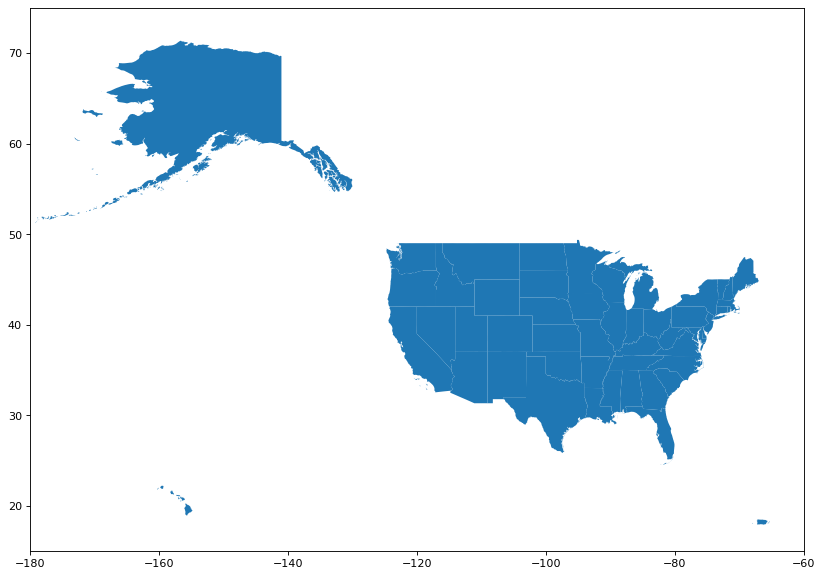

In [10]:
fig, ax = plt.subplots(figsize=(16, 9),dpi=80)
ax = US_gpd.plot(ax=ax)

plt.xlim([-180, -60])
plt.ylim([15, 75])
plt.show()

### Tighten up the view

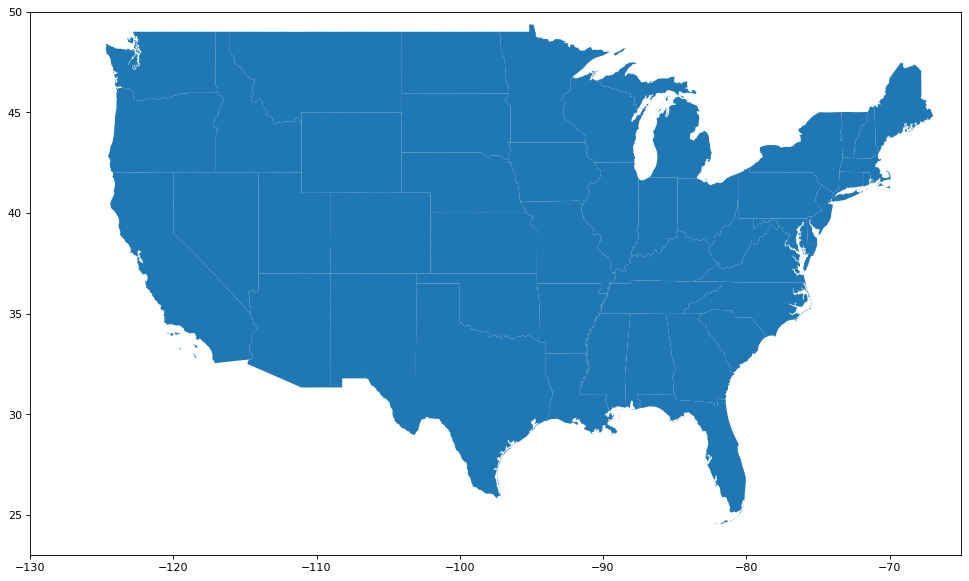

In [11]:
fig, ax = plt.subplots(figsize=(16, 9),dpi=80)
ax = US_gpd.plot(ax=ax)

plt.xlim([-130, -65])
plt.ylim([23, 50])
plt.show()

In [12]:
#us["area"] = us.area
#us.explore("area", legend=False)

### Add label & arrow for state name

Get coordinate for state name label

In [13]:
def get_Coords(df_Main):
    df_Main['coords'] = df_Main['geometry'].apply(lambda x: x.representative_point().coords[:])
    df_Main['coords'] = [coords[0] for coords in df_Main['coords']]
    return df_Main

US_gpd = get_Coords(US_gpd)

Manual improvement of some state name overlap problems

In [14]:
# list of overlap states
overlap_state = ['Vermont','New Hampshire','Massachusetts','Rhode Island','Connecticut','New Jersey','Delaware','Maryland','West Virginia','District of Columbia','Alabama']

old_position = {'Vermont':[-72.7721723206516, 43.871287499999994],\
                'New Hampshire':[-71.55153363075382, 44.001686],\
                'Massachusetts':[-72.0906137083712, 42.148081000000005],\
                'Rhode Island':[-71.59827076340775, 41.662519],\
                'Connecticut':[-72.66284659760579, 41.5034435],\
                'New Jersey':[-74.37884099984127, 40.1403525],\
                'Delaware':[-75.5789503410023, 39.149795499999996],\
                'Maryland':[-76.75274030690827, 38.817387],\
                'West Virginia':[-80.29656250731031, 38.918831499999996],\
                'District of Columbia':[-76.98977922083728, 38.8960115],\
                'Alabama':[-86.73307855039542, 32.613208]
               }

new_position = {'Vermont':[-72.7721723206516, 46.871287499999994],\
                'New Hampshire':[-62.55153363075382, 44.001686],\
                'Massachusetts':[-62.590613708371194, 42.648081000000005],\
                'Rhode Island':[-63.098270763407754, 41.162519],\
                'Connecticut':[-64.16284659760579, 40.103443500000004],\
                'New Jersey':[-63.98977922083728, 38.8960115],\
                'Delaware':[-66.12884099984127, 37.6903525],\
                'Maryland':[-67.3289503410023, 36.4997955],\
                'West Virginia':[-79.79656250731031, 44.068831499999995],\
                'District of Columbia':[-68.75274030690827, 35.317387],\
                'Alabama':[-86.73307855039542, 26.613208]
               }

arrow_position = {'Vermont':[-72.7721723206516, 46.871287499999994],\
                'New Hampshire':[-66.15153363075382, 44.401686],\
                'Massachusetts':[-65.880613708371194, 42.898081000000005],\
                'Rhode Island':[-65.998270763407754, 41.562519],\
                'Connecticut':[-66.96284659760579, 40.403443500000004],\
                'New Jersey':[-66.70977922083728, 39.2060115],\
                'Delaware':[-68.12884099984127, 38.0203525],\
                'Maryland':[-69.3289503410023, 36.9597955],\
                'West Virginia':[-79.79656250731031, 44.068831499999995],\
                'District of Columbia':[-69.75274030690827, 35.917387],\
                'Alabama':[-86.73307855039542, 27.013208]
               }

In [15]:
# Check old position by overlap state list
for s in overlap_state:
    print(US_gpd.at[s,'coords'])
    
# Change and seek for new location
#s = overlap_state[10]
#y = US_gpd.loc[s]['coords']
#x -= 0.25
#y += 0.15
#US_gpd.at[s,'coords'] = (x,y)
#US_gpd.at[s,'coords']

(-72.7721723206516, 43.871287499999994)
(-71.55153363075382, 44.001686)
(-72.0906137083712, 42.148081000000005)
(-71.59827076340775, 41.662519)
(-72.66284659760579, 41.5034435)
(-74.37884099984127, 40.1403525)
(-75.5789503410023, 39.149795499999996)
(-76.75274030690827, 38.817387)
(-80.29656250731031, 38.918831499999996)
(-76.98977922083728, 38.8960115)
(-86.73307855039542, 32.613208)


In [16]:
# Change location by position dict
df_new_pos = pd.DataFrame.from_dict(new_position,orient='index')
df_old_pos = pd.DataFrame.from_dict(old_position,orient='index')
df_arrow_pos = pd.DataFrame.from_dict(arrow_position,orient='index')

# Construct tuple for coords with x and y axis position
df_new_pos['coords']=df_new_pos[[0,1]].apply(tuple,axis=1)
df_old_pos['old_coords']=df_old_pos[[0,1]].apply(tuple,axis=1)
df_arrow_pos['arrow_coords']=df_arrow_pos[[0,1]].apply(tuple,axis=1)

# Drop the useless columns
df_new_pos = df_new_pos.drop(columns=[0,1])
df_old_pos = df_old_pos.drop(columns=[0,1])
df_arrow_pos = df_arrow_pos.drop(columns=[0,1])

# Update the original table
US_gpd.update(df_new_pos)

# Merge new & old position in one df
df_overlap_pos = pd.concat([df_new_pos, df_old_pos], axis = 1)
df_overlap_pos = pd.concat([df_overlap_pos, df_arrow_pos], axis = 1)
df_overlap_pos = df_overlap_pos.rename(columns={'coords':'new','old_coords':'old','arrow_coords':'arrow'})

In [17]:
df_overlap_pos.head()

,new,old,arrow
Vermont,"(-72.7721723206516, 46.871287499999994)","(-72.7721723206516, 43.871287499999994)","(-72.7721723206516, 46.871287499999994)"
New Hampshire,"(-62.55153363075382, 44.001686)","(-71.55153363075382, 44.001686)","(-66.15153363075382, 44.401686)"
Massachusetts,"(-62.590613708371194, 42.648081000000005)","(-72.0906137083712, 42.148081000000005)","(-65.8806137083712, 42.898081000000005)"
Rhode Island,"(-63.098270763407754, 41.162519)","(-71.59827076340775, 41.662519)","(-65.99827076340776, 41.562519)"
Connecticut,"(-64.16284659760579, 40.103443500000004)","(-72.66284659760579, 41.5034435)","(-66.96284659760579, 40.4034435)"


# Visualising NEV sales
Add the ev sales data into the map dataframe as follows:

In [18]:
US_Sales = pd.concat([df_EV, US_gpd], axis = 1)
US_Sales['State'] = US_Sales.index
US_Sales['Avg'] = US_Sales[['2016','2017','2018','2019']].mean(axis=1)
US_Sales.head()

,2016,2017,2018,2019,geometry,coords,State,Avg
California,73854.0,94873.0,153442.0,145020.0,"MULTIPOLYGON (((-122.42144 37.86997, -122.4213...","(-119.9915015382688, 37.27239)",California,116797.25
New York,6043.0,10090.0,15752.0,14823.0,"MULTIPOLYGON (((-74.04086 40.70012, -74.04002 ...","(-76.07275168890986, 42.777108)",New York,11677.00
Washington,5363.0,7068.0,12650.0,12172.0,"MULTIPOLYGON (((-122.51954 48.28831, -122.5227...","(-119.73301840693637, 47.2734285)",Washington,9313.25
Florida,6255.0,6573.0,13705.0,15794.0,"MULTIPOLYGON (((-82.82158 27.96444, -82.82980 ...","(-81.6708163436505, 28.075761999999997)",Florida,10581.75
Texas,4510.0,5419.0,11764.0,5780.0,"MULTIPOLYGON (((-97.13436 27.89633, -97.13360 ...","(-99.68487437861657, 31.1710505)",Texas,6868.25


Try converting the merged dataframe into a geodataframe

In [19]:
US_Sales = GeoDataFrame(US_Sales)

devide data into main & outside

In [20]:
df_Alaska = US_Sales[US_Sales.index == 'Alaska']
df_Hawaii = US_Sales[US_Sales.index == 'Hawaii']
df_Main = US_Sales.drop(index=('Alaska'))
df_Main = df_Main.drop(index=('Hawaii'))
len(US_Sales),len(df_Main)

(52, 50)

Re-draw the graph to use the sales data as the basis for each county's colour through setup the colour map.

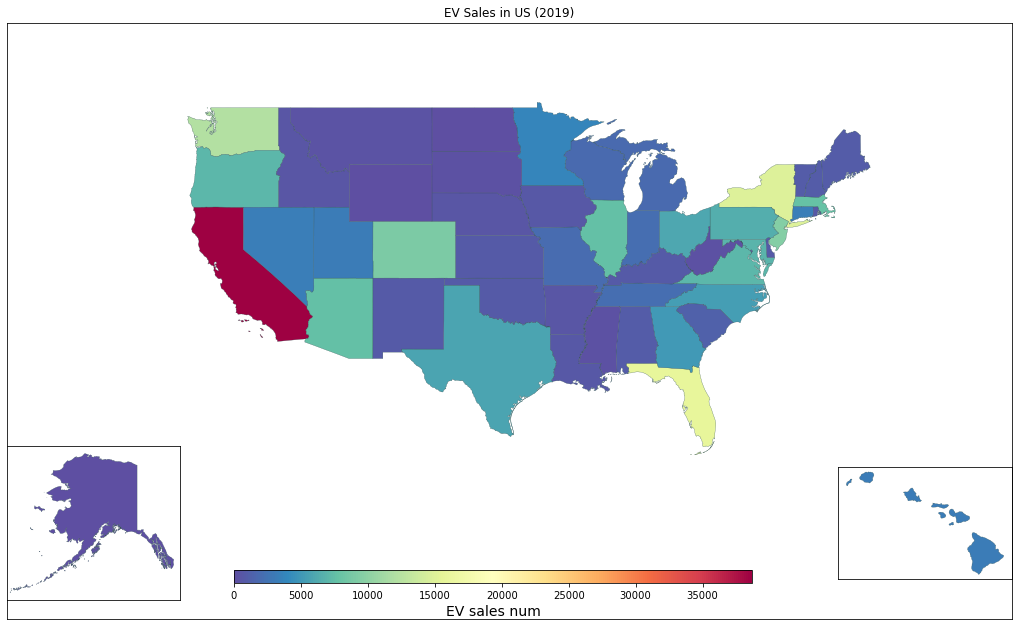

In [21]:
fig = plt.figure(figsize=[18,18])
ax = fig.add_subplot(111)

# Since California has the highest number and is 9.7 times than others, 
# we used the average of the top 5 to adjust our color range.
max_sale = US_Sales['2019'].head(5).mean()

# Setup the colour map and normalise it.
norm = matplotlib.colors.Normalize(vmin=0, vmax=max_sale)
cmap = matplotlib.cm.get_cmap('Spectral_r')

# Draw US main map
df_Main.plot(column='2019', cmap=cmap, norm=norm, ax=ax, lw=.25, edgecolor='darkslategrey')

# Tighten up the view
plt.xlim([-140, -55])
plt.ylim([13, 55])

# Remove unnecessary tick marks.
def remove_tick_mark(ax):
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
remove_tick_mark(ax)

# Set title label.
ax.set_title('EV Sales in US (2019)')

# Add the colour bar and label it.
cax = fig.add_axes([.3, .30, .4, .01])
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', orientation='horizontal')
cb.set_label('EV sales num', fontsize=14)


# Draw Alaska Map
ax = fig.add_subplot(5,5,16)
df_Alaska.plot(column='2019', cmap=cmap, norm=norm, ax=ax, lw=.25, edgecolor='darkslategrey')
# Tighten up the view
plt.xlim([-180, -128])
# Remove unnecessary tick marks.
remove_tick_mark(ax)

# Draw Hawaii Map
ax = fig.add_subplot(5,5,20)
df_Hawaii.plot(column='2019', cmap=cmap, norm=norm, ax=ax, lw=.25, edgecolor='darkslategrey')
# Remove unnecessary tick marks.
remove_tick_mark(ax)

### Draw map with state name

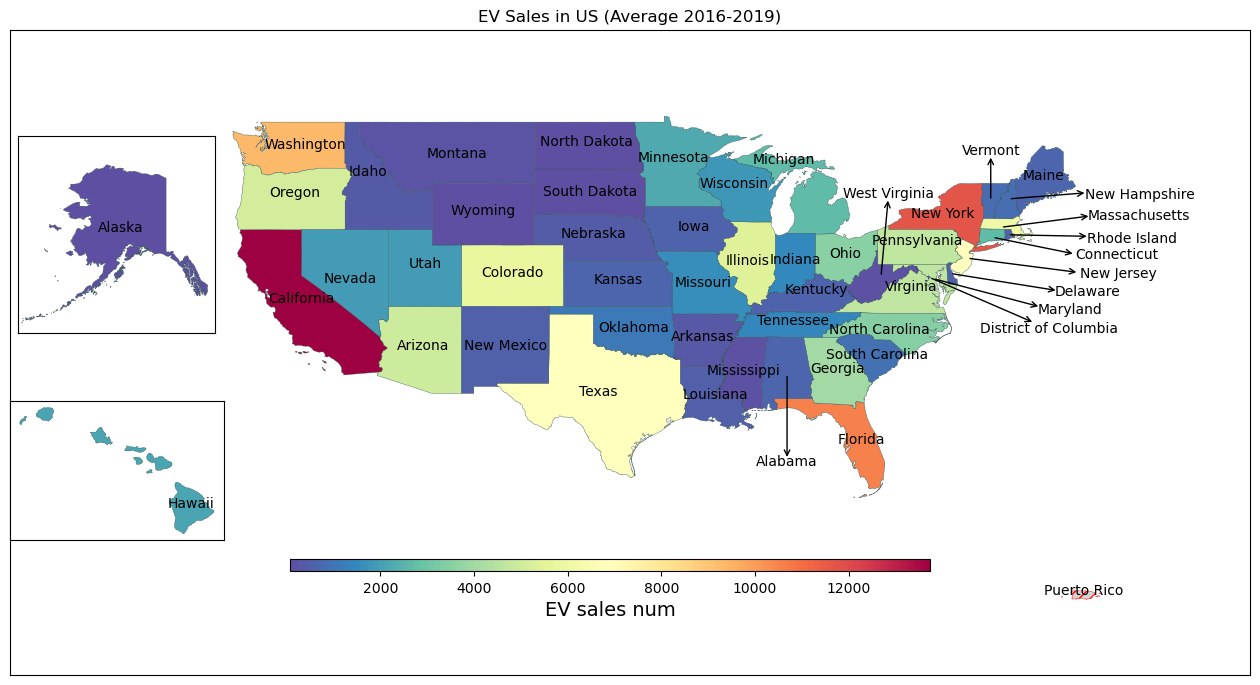

In [22]:
def draw_US_map_with_label(max_,min_,df_Main,df_Alaska,df_Hawaii,title,bar_title,c_ax):
    fig = plt.figure(figsize=[16,12],dpi=100)
    ax = fig.add_subplot(111)
    
    # Setup the colour map and normalise it.
    norm = matplotlib.colors.Normalize(vmin=min_, vmax=max_)
    cmap = matplotlib.cm.get_cmap('Spectral_r')

    # Draw US main map
    df_Main.plot(column='Avg', cmap=cmap, norm=norm, ax=ax, lw=.25, edgecolor='darkslategrey',\
                 missing_kwds={"color": "lightgrey","edgecolor": "red","hatch": "///","label": "Missing values"})

    # Draw state names
    for idx, row in df_Main.iterrows():
       plt.annotate(text=row['State'], xy=row['coords'], horizontalalignment='center', color='black')
    # Draw arrow for overlapped name
    for idx, row in df_overlap_pos.iterrows():
        ax.annotate("", xy=row['arrow'], xytext=row['old'],arrowprops=dict(arrowstyle="->"))
    
    # Tighten up the view
    plt.xlim([-140, -55])
    plt.ylim([13, 55])

    # Remove unnecessary tick marks.
    remove_tick_mark(ax)

    # Set title label.
    ax.set_title(title)

    # Add the colour bar and label it.
    cax = fig.add_axes(c_ax)
    cb = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', orientation='horizontal')
    cb.set_label(bar_title, fontsize=14)

    # Draw Alaska Map
    ax = fig.add_subplot(4,5,6)
    df_Alaska.plot(column='Avg', cmap=cmap, norm=norm, ax=ax, lw=.25, edgecolor='darkslategrey',\
                   missing_kwds={"color": "lightgrey","edgecolor": "red",\
                                 "hatch": "///","label": "Missing values"}\
                  )
    # Tighten up the view
    plt.xlim([-180, -128])
    plt.ylim([50,75])
    # Show Alaska name
    plt.annotate(text='Alaska', xy=df_Alaska['coords']['Alaska'], horizontalalignment='center', color='black')
    # Remove unnecessary tick marks.
    remove_tick_mark(ax)
    
    # Draw Hawaii Map
    ax = fig.add_subplot(4,5,11)
    df_Hawaii.plot(column='Avg', cmap=cmap, norm=norm, ax=ax, lw=.25, edgecolor='darkslategrey',\
                   missing_kwds={"color": "lightgrey","edgecolor": "red",\
                                 "hatch": "///","label": "Missing values"}\
                  )
    # Show Hawaii name
    plt.annotate(text='Hawaii', xy=df_Hawaii['coords']['Hawaii'], horizontalalignment='center', color='black');
    # Remove unnecessary tick marks.
    remove_tick_mark(ax)
    
    return fig
# Since California has the highest number and is 9.7 times than others, 
# we used the average of the top 15 to adjust our color range.
max_sale = US_Sales['Avg'].head(15).mean()
min_sale = US_Sales['Avg'].min()
title = 'EV Sales in US (Average 2016-2019)'
bar_title = 'EV sales num'
# Set colour bar position.
c_ax = [.3, .32, .4, .01]
fig = draw_US_map_with_label(max_sale,min_sale,df_Main,df_Alaska,df_Hawaii,title,bar_title,c_ax)

# Save as png inmage
fig.savefig('./US_Maps/EV_Sales_in_US.png', format='png')

## Show Climate Map

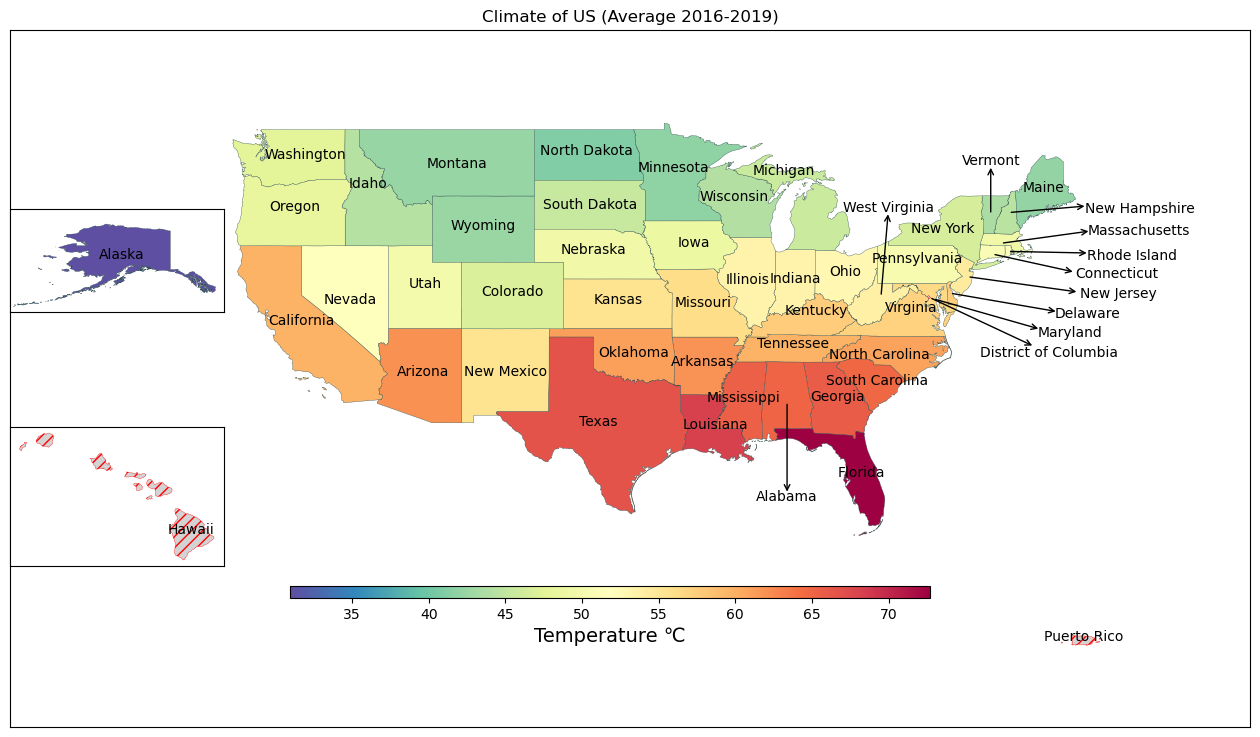

In [23]:
US_Climate = pd.concat([df_Climate[['2016','2017','2018','2019']].mean(axis=1), US_gpd], axis = 1)
US_Climate = US_Climate.rename(columns={0: 'Avg'})
US_Climate['State'] = US_Climate.index

US_Climate = GeoDataFrame(US_Climate)

df_Alaska_c = US_Climate[US_Climate.index == 'Alaska']
df_Hawaii_c = US_Climate[US_Climate.index == 'Hawaii']
df_Main_c = US_Climate.drop(index=('Alaska'))
df_Main_c = df_Main_c.drop(index=('Hawaii'))

# Setting for adjust color range
max_temp = US_Climate['Avg'].max()
min_temp = US_Climate['Avg'].min()
title = 'Climate of US (Average 2016-2019)'
bar_title = 'Temperature ℃'
# Set colour bar position.
c_ax = [.3, .32, .4, .01]
fig = draw_US_map_with_label(max_temp,min_temp,df_Main_c,df_Alaska_c,df_Hawaii_c,title,bar_title,c_ax)

# Save as png inmage
fig.savefig('./US_Maps/Climate_in_US.png', format='png')

## Show Income Map

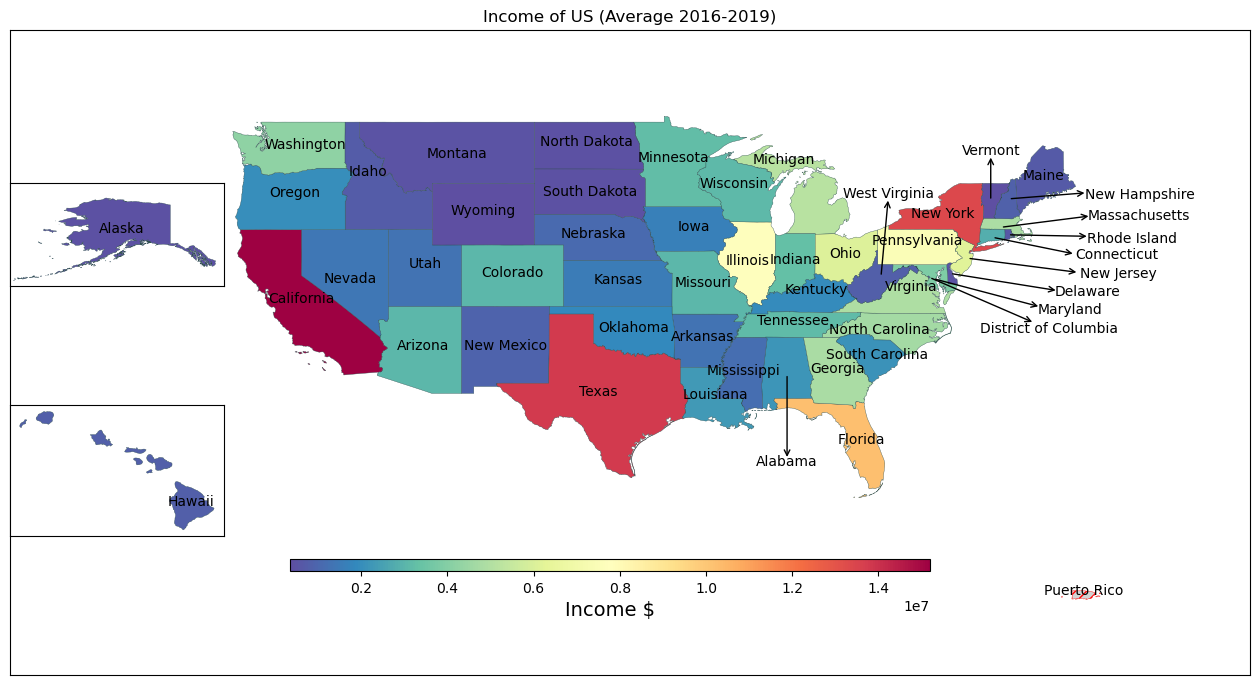

In [24]:
US_Income = pd.concat([df_Income[['2016','2017','2018','2019']].mean(axis=1).round(2), US_gpd], axis = 1)
US_Income = US_Income.rename(columns={0: 'Avg'})
US_Income['State'] = US_Income.index

US_Income = GeoDataFrame(US_Income)

df_Alaska_i = US_Income[US_Income.index == 'Alaska']
df_Hawaii_i = US_Income[US_Income.index == 'Hawaii']
df_Main_i = US_Income.drop(index=('Alaska'))
df_Main_i = df_Main_i.drop(index=('Hawaii'))

# Setting for adjust color range
US_Income = US_Income.sort_values(by=['Avg'],ascending=False)
max_income = US_Income['Avg'].head(4).mean()
min_income = US_Income['Avg'].min()
title = 'Income of US (Average 2016-2019)'
bar_title = 'Income $'
# Set colour bar position.
c_ax = [.3, .32, .4, .01]
fig = draw_US_map_with_label(max_income,min_income,df_Main_i,df_Alaska_i,df_Hawaii_i,title,bar_title,c_ax)

# Save as png inmage
fig.savefig('./US_Maps/Income_in_US.png', format='png')

## Show Tax Map

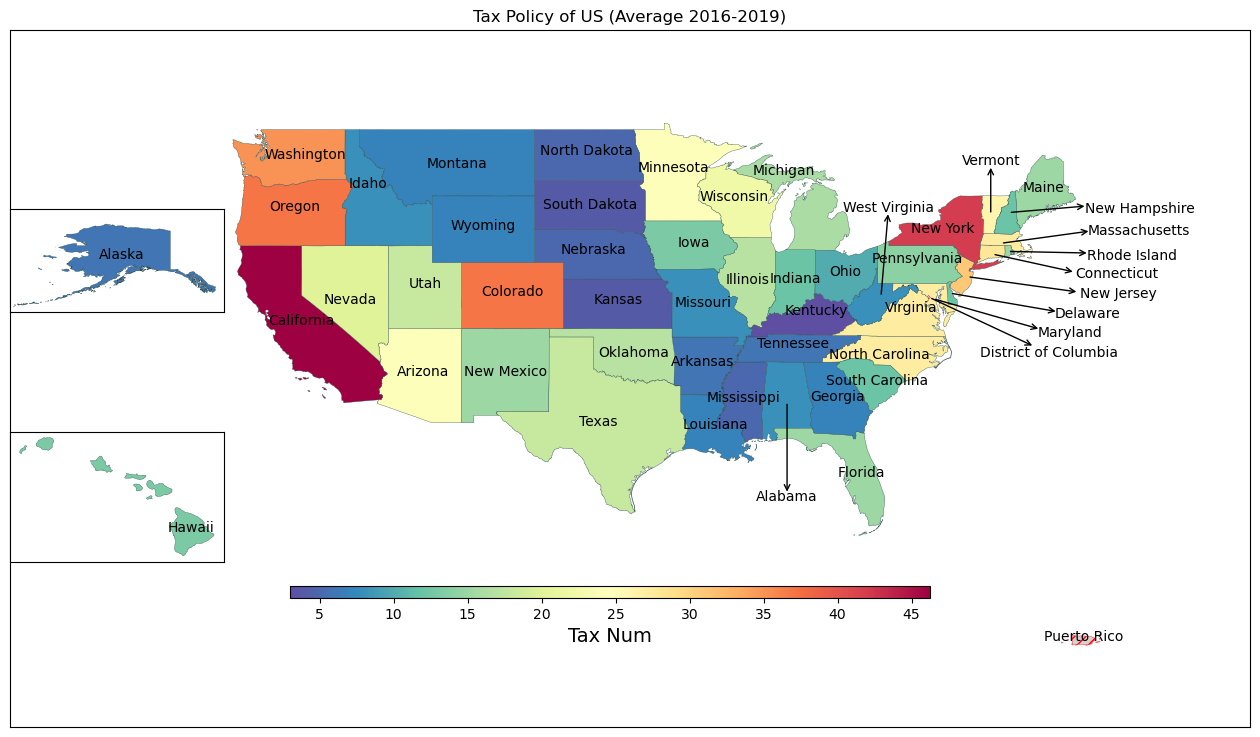

In [25]:
US_Tax = pd.concat([df_Tax['Total'], US_gpd], axis = 1)
US_Tax = US_Tax.rename(columns={'Total': 'Avg'})
US_Tax['State'] = US_Tax.index

US_Tax = GeoDataFrame(US_Tax)

df_Alaska_t = US_Tax[US_Tax.index == 'Alaska']
df_Hawaii_t = US_Tax[US_Tax.index == 'Hawaii']
df_Main_t = US_Tax.drop(index=('Alaska'))
df_Main_t = df_Main_t.drop(index=('Hawaii'))

# Setting for adjust color range
US_Tax = US_Tax.sort_values(by=['Avg'],ascending=False)
max_tax = US_Tax['Avg'].head(8).mean()
min_tax = US_Tax['Avg'].min()
title = 'Tax Policy of US (Average 2016-2019)'
bar_title = 'Tax Num'
# Set colour bar position.
c_ax = [.3, .32, .4, .01]
fig = draw_US_map_with_label(max_tax,min_tax,df_Main_t,df_Alaska_t,df_Hawaii_t,title,bar_title,c_ax)

# Save as png inmage
fig.savefig('./US_Maps/Tax_in_US.png', format='png')

## Show GDP Map

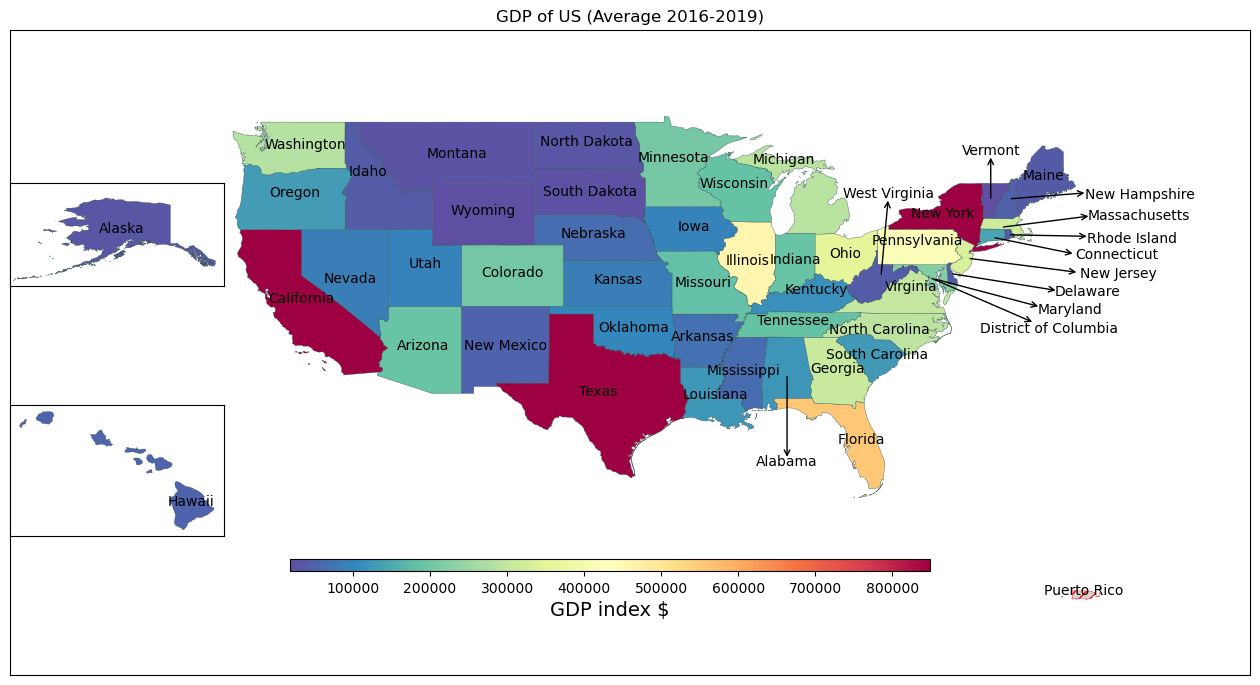

In [26]:
US_GDP = pd.concat([df_GDP[['2016','2017','2018','2019']].mean(axis=1).round(2), US_gpd], axis = 1)
US_GDP = US_GDP.rename(columns={0: 'Avg'})
US_GDP['State'] = US_GDP.index

US_GDP = GeoDataFrame(US_GDP)

df_Alaska_g = US_GDP[US_GDP.index == 'Alaska']
df_Hawaii_g = US_GDP[US_GDP.index == 'Hawaii']
df_Main_g = US_GDP.drop(index=('Alaska'))
df_Main_g = df_Main_g.drop(index=('Hawaii'))

# Setting for adjust color range
US_GDP = US_GDP.sort_values(by=['Avg'],ascending=False)
max_gdp = US_GDP['Avg'].head(5).mean()
min_gdp = US_GDP['Avg'].min()
title = 'GDP of US (Average 2016-2019)'
bar_title = 'GDP index $'
# Set colour bar position.
c_ax = [.3, .32, .4, .01]
fig = draw_US_map_with_label(max_gdp,min_gdp,df_Main_g,df_Alaska_g,df_Hawaii_g,title,bar_title,c_ax)

# Save as png inmage
fig.savefig('./US_Maps/GDP_in_US.png', format='png')